# Generating adversarial images with Keras
Presenting an adversarial mask/patch generator

## Random image transformations for use with the adversarial patch

Test image with random transform: 1


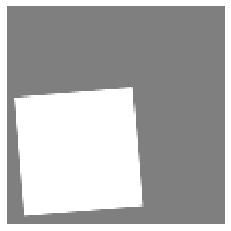

Test image with random transform: 2


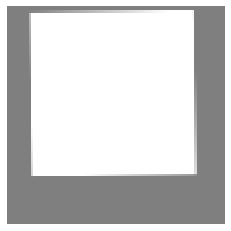

In [3]:
from patch.transformations import test_random_transform
for i in range(2):
  print("Test image with random transform: %s" % (i+1))
  test_random_transform(min_scale=0.25, max_scale=2.0, max_rotation=22.5)

In [4]:
import json
from patch.model_state import ModelContainer

with open('config.json') as json_file:
    config = json.load(json_file)
    
STEPS = config["patch_epochs"]

# custom_weights_path points to a pre-trained model on 10 classes of images
mc = ModelContainer("SimpleVGG16", custom_weights_path="cool_net.h5")

print("Training SimpleVGG16")
mc.reset_patch()
for i in range(STEPS):
    loss = mc.train_step(scale=(0.1, 1.0))
    if i % int(STEPS/10) == 0:
        print("[%s] loss: %s" % (i, loss))

print("Done training!")
patch = mc.patch()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://gi

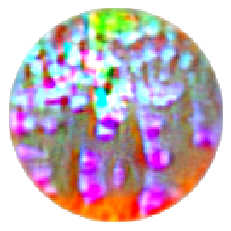

In [27]:
from patch.constants import PATCH_SHAPE
from patch.image import show
from patch.model_state import circle_mask

def show_patch(patch):
  circle = circle_mask(PATCH_SHAPE)
  show(circle * patch + (1-circle))
    
show_patch(patch)

LogLoss: -1.7 	Win Rate: 96%	 Top5: 100%	n: 32


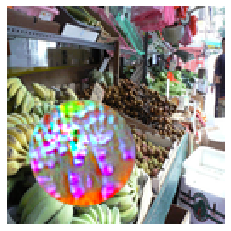

stephen                        0.99
banana                         0.01
racecar                        0.00
apple                          0.00
orange                         0.00



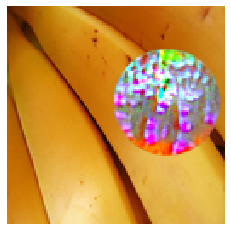

stephen                        1.00
afterburner                    0.00
slav                           0.00
orange                         0.00
apple                          0.00



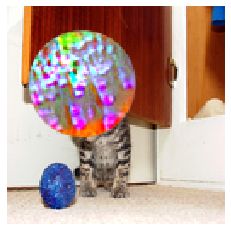

stephen                        1.00
banana                         0.00
apple                          0.00
afterburner                    0.00
racecar                        0.00



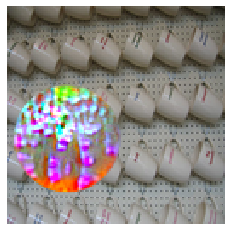

stephen                        1.00
banana                         0.00
racecar                        0.00
mug                            0.00
apple                          0.00



{'logloss': -1.731975822768333,
 'win': 96,
 'top5': 100,
 'time': 2.0551979541778564,
 'loss': 0.17693447321653366}

In [26]:
import matplotlib.pyplot as plt
import time
import math
import numpy as np
from patch.constants import BATCH_SIZE, TARGET_LABEL, LABELS

def show2(im):
  plt.axis('off')
  plt.imshow(im, interpolation="nearest")
  plt.show()

def label_to_name(label):
  return LABELS[label]

def report(model, step=None, show_images=False, n=400, verbose=True, scale=(0.1, 1.0)):
  """Prints a report on how well the model is doing.
  If you want to see multiple samples, pass a positive int to show_images
  
  Model can be a ModelContainer instance, or a string. If it's a string, we
  lookup that model name in the MultiModel
  """
  start = time.time()
  # n examples where target was in top 5
  top_5 = 0
  # n examples where target was top 1
  wins = 0
  # n examples in total
  n_batches = int(math.ceil(float(n) / BATCH_SIZE))
  total = BATCH_SIZE * n_batches
  
  loss = 0
  
  for b in range(n_batches):
    if isinstance(model, str):
      loss_per_example, probs, patched_imgs = M.inference_batch(model, scale=scale)
    else:
      loss_per_example, probs, patched_imgs = model.inference_batch(scale=scale)
    
    loss += np.mean(loss_per_example)
    for i in range(BATCH_SIZE):
      top_labels = np.argsort(-probs[i])[:5]
      if TARGET_LABEL in top_labels:
        top_5 += 1
        if top_labels[0] == TARGET_LABEL:
          wins += 1
  loss = loss / n_batches
  top_5p = int(100 * float(top_5) / total)
  winp = int(100 * float(wins) / total)
  
  if step is not None:
    r = 'Step: {} \t'.format(step)
  else:
    r = ''
  r += 'LogLoss: {:.1f} \tWin Rate: {}%\t Top5: {}%\tn: {}'.format(math.log(loss), winp, top_5p, total)
  if verbose:
    print(r)
  
  if show_images:
    if show_images is True:
      show_images = 1
    _visualize_example(patched_imgs, probs, loss_per_example, show_images)
  elapsed = time.time() - start
  return {'logloss': math.log(loss), 'win': winp, 'top5': top_5p, 'time': elapsed, 'loss': loss}

def _visualize_example(patched_imgs, probs, loss_per_example, n_reports=1):
  for i in range(n_reports):
    show(patched_imgs[i])
    
    predictions_str = ''
    top_label_ids = np.argsort(-probs[i])[:5]
    for label in top_label_ids:
      p = probs[i][label]
      name = label_to_name(label)
      if len(name) > 30:
        name = name[:27] + "..."
      if name == "toaster":
        predictions_str += "\033[1m"
      name = name.ljust(30, " ")
      predictions_str += "{} {:.2f}".format(name, p)
      if name.startswith("toaster"):
        predictions_str += "\033[0m"
      predictions_str += "\n"
    #predictions_str += "\033[1mLogLoss: {:.1f}\033[0m\n".format(math.log(loss_per_example[i]))
  
    print(predictions_str)
    
report(mc, n=32, show_images=3, scale=0.5)